# Benchmarking Raspberry Pi + Intel Movidius using Inception v1

# Environment setup
To measure the current consumption I measured the voltage drop in a resistor.
* The resistor was supposed to be 1 Ohm ± 1% ([RS0051R000FE12](https://www.mouser.es/productdetail/vishay-dale/rs0051r000fe12?qs=%252b%2f1MMOhkBTf5JUBsk0YDOg==)), but when measuring with the multimiter it turned out to be 1.6 Ohms.
* The 10x attenuator was enabled in the oscilloscope probes but not on the scope. This means that to obtain the real voltages, the data has to be multiplied by ten.
* The voltage input was actually not 5V. It was a bit higher to feed the Raspberry Pi with a value closer to 5V when the current consumption increased.
* The static current consumption of the setup before starting the inference (i.e. before executing `make VERSION=V1 infer`) was between 200 and 300 mA. This is the power drained by Raspberry Pi B+ v1.2 running clean Raspbian (with the Movidius tools installed), connected through Ethernet.

![Setup](measurements/setup.png)

## Screenshot from the oscilloscope
This screenshot shows the entire duration of the command `make VERSION=v1 infer`. The data that we will be using from the CSV corresponds to the second peak and each peak corresponds to one inference. Since the first one initialises some data structures that will be reused in the upcoming inferences, we discard it because usually we would not be performing a single analysis. 

![2x inferences](measurements/v1/2x_inferences.png)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

## Output (accuracy and latency)

In [2]:
! cat measurements/v1/output.txt

pi@raspberrypi:~/oscw18-edge-ai/movidius $ make VERSION=v1 infer INPUT=data/pic_002.jpg 

Running inferences on data/pic_002.jpg...
(python3 image-classifier.py --graph ./model/v1/inception_v1_ncgraph --dim 224 224 --mean 127.5 --scale 0.00789 --colormode "RGB" --labels ./model/v1/labels.txt --image data/pic_002.jpg)

Top predictions for pic_002.jpg
Execution time: 88.4408ms
--------------------------------------------------------------
73.8%   288:lynx, catamount
8.3%    283:tiger cat
4.9%    282:tabby, tabby cat
4.3%    284:Persian cat
1.2%    286:Egyptian cat


## Parse raw data 

In [3]:
df_params = pd.read_csv("measurements/v1/second_inference.csv", nrows=1, usecols=['Start', 'Increment'])
period_ms = df_params['Increment'][0] * 1000
period_ms

0.1

In [4]:
df_val = pd.read_csv("measurements/v1/second_inference.csv", skiprows=[1], usecols=['X', 'CH1', 'CH2'])
df_val.loc[:, 'X'] *= period_ms

# probes were in 10x scale, scope in 1x
df_val.loc[:, 'CH1'] *= 10
df_val.loc[:, 'CH2'] *= 10

df_val.rename(index=str, columns={'X': 'time [ms]', 'CH1': 'vout [V]', 'CH2': 'vin [V]'}, inplace=True)
df_val[:10]

,time [ms],vout [V],vin [V]
0,0.0,4.86,5.27
1,0.1,4.90,5.32
2,0.2,4.90,5.28
3,0.3,4.86,5.32
4,0.4,4.89,5.32
5,0.5,4.86,5.27
6,0.6,4.86,5.32
7,0.7,4.89,5.28
8,0.8,4.86,5.32
9,0.9,4.89,5.27


# Obtaining power consumption

In [5]:
R = 1.6 # ohm
static_curr = 200 # [mA] lowest value to avoid having negative power consumptions
df_val['total curr [mA]'] = (df_val['vin [V]'] - df_val['vout [V]']) * 1000 / R
df_val['curr [mA]'] = (df_val['vin [V]'] - df_val['vout [V]']) * 1000 / R - static_curr

df_val['total pow [mW]'] = df_val['total curr [mA]'] * df_val['vout [V]']
df_val['pow [mW]'] = df_val['curr [mA]'] * df_val['vout [V]']
df_val[:10]

,time [ms],vout [V],vin [V],total curr [mA],curr [mA],total pow [mW],pow [mW]
0,0.0,4.86,5.27,256.25,56.25,1245.3750,273.3750
1,0.1,4.90,5.32,262.50,62.50,1286.2500,306.2500
2,0.2,4.90,5.28,237.50,37.50,1163.7500,183.7500
3,0.3,4.86,5.32,287.50,87.50,1397.2500,425.2500
4,0.4,4.89,5.32,268.75,68.75,1314.1875,336.1875
5,0.5,4.86,5.27,256.25,56.25,1245.3750,273.3750
6,0.6,4.86,5.32,287.50,87.50,1397.2500,425.2500
7,0.7,4.89,5.28,243.75,43.75,1191.9375,213.9375
8,0.8,4.86,5.32,287.50,87.50,1397.2500,425.2500
9,0.9,4.89,5.27,237.50,37.50,1161.3750,183.3750


Text(0.5,1,'Power')

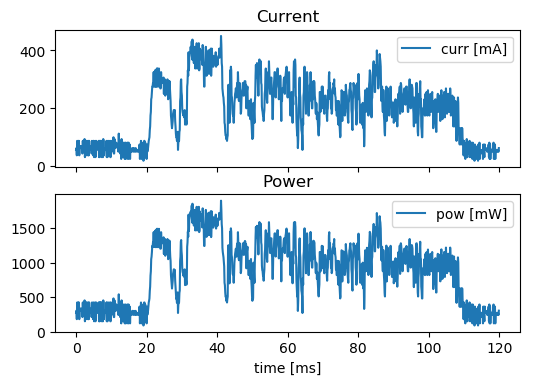

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, dpi=100)

df_val.plot(ax=ax1, x='time [ms]', y='curr [mA]')
ax1.set_title("Current")
df_val.plot(ax=ax2, x='time [ms]', y='pow [mW]')
ax2.set_title("Power")

## Obtaining total energy consumption

In [7]:
energy = df_val['curr [mA]'].sum() * period_ms # mA*ms
energy /= (1000 * 3600) # mAh

energy_tot = df_val['total curr [mA]'].sum() * period_ms # mA*ms
energy_tot /= (1000 * 3600) # mAh

print("Energy consumed during 1 inference ", energy)
print("Total energy consumed during 1 inference ", energy_tot)

Energy consumed during 1 inference  0.006510243055555561
Total energy consumed during 1 inference  0.013176909722222229


In [8]:
# TODO how many inferences could we do in 1 hour
# TODO how many inferences could we do with a 1000 mAh battery (graph with many typical battery capacities)
# TODO peak power consumption (total and without taking into account static consumption)
# TODO discard current values before the inference (peak) starts